In [1]:

# The VAE has a modular design. The encoder, decoder and VAE
# are 3 models that share weights. After training the VAE model,
# the encoder can be used to generate latent vectors.
# The decoder can be used to generate MNIST digits by sampling the
# latent vector from a Gaussian distribution with mean = 0 and std = 1.
# # Reference
# [1] Kingma, Diederik P., and Max Welling.
# "Auto-Encoding Variational Bayes."
# https://arxiv.org/abs/1312.6114


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, y_train.shape)

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape, y_train.shape)

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



Using TensorFlow backend.


(60000, 28, 28) (60000,)
(60000, 784) (60000,)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]           

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


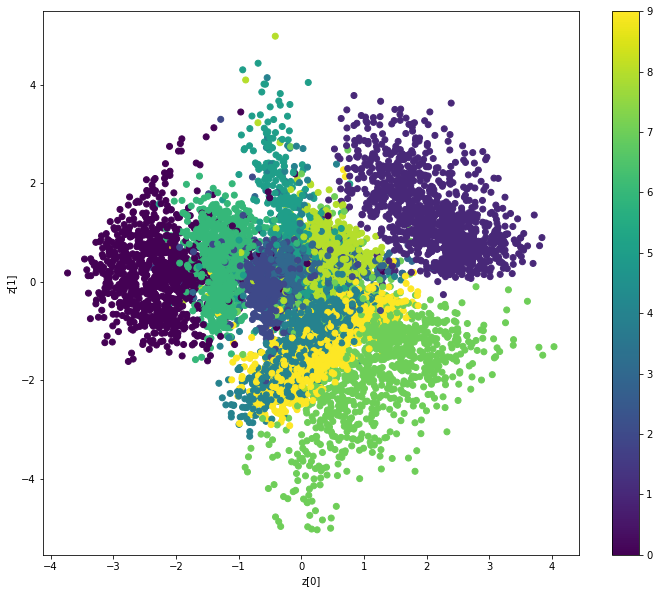

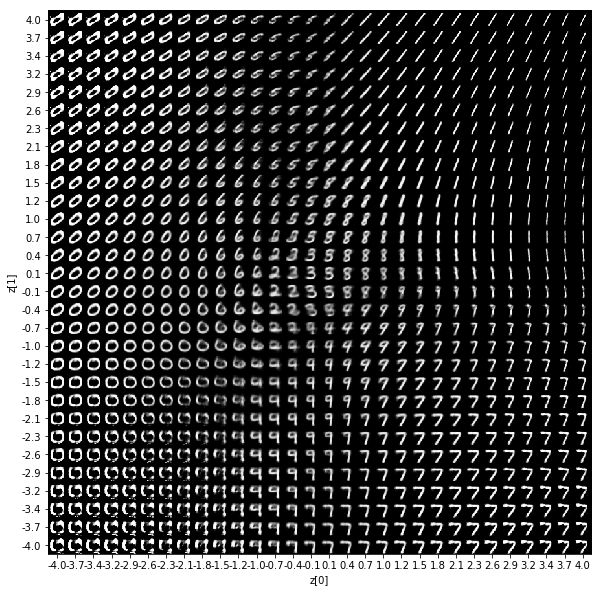

In [2]:
if __name__ == '__main__':

    models = (encoder, decoder)
    data = (x_test, y_test)
    loss = "binary"
    trained = "no'/"
    # VAE loss = mse_loss or xent_loss + kl_loss
    if loss == "mse":
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)

#     if trained == "yes":
#         vae.load_weights(args.weights)
#     else:
#         # train the autoencoder
#         vae.fit(x_train,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 validation_data=(x_test, None))
        #vae.save_weights('vae_mlp_mnist.h5')

    vae.load_weights('vae_mlp_mnist.h5')
    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [3]:
from keras.models import Sequential
from keras.layers import Dense
enc_model = Sequential()
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(100, activation='softmax')(latent_inputs)
mid = Dense(100, activation='softmax')(x)
y = Dense(10, activation='softmax')(x)
enc_ffn = Model(latent_inputs, y, name='enc_ffn')
enc_ffn.summary()
plot_model(enc_ffn, to_file='enc_ffn.png', show_shapes=True)
# enc_model.add(Dense(100, activation ='softmax', input_dim=2))
# enc_model.add(Dense(10, activation ='softmax'))
enc_ffn.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])
#print(encoder(inputs)[2])
train_enc = encoder.predict(x_train)[2]
test_enc = encoder.predict(x_test)[2]
print(test_enc[0].shape)              
#enc_ffn.fit(train_enc, y_train, epochs=200, batch_size=256, verbose=2)
enc_ffn.load_weights('enc_ffn.h5')
scores = enc_ffn.evaluate(test_enc, y_test, verbose=0)
print("Part 2 score: ",scores)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
_________________________________________________________________
(2,)
Part 2 score:  [0.7780025463104248, 0.7435]


In [0]:
#enc_ffn.save_weights('enc_ffn.h5')

In [5]:
enc_ffn.summary()
plot_model(enc_ffn, to_file='enc_ffn.png', show_shapes=True)
f_outputs = enc_ffn(encoder(inputs)[2])
final_model = Model(inputs, f_outputs, name='final_model')
final_model.summary()
plot_model(final_model, to_file='final_model.png', show_shapes=True)
final_model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
enc_ffn 

In [0]:
# first_img = x_train[3]
# first_img = first_img.reshape((-1,28*28))
# plot_img = first_img.reshape((28,28))
# plt.imshow(plot_img)
# plt.figure()
# print(final_model.predict(first_img))

# plot_img *= 255.
# # print(plot_img)
# # print(first_img)
# plot_img = plot_img.astype(np.uint8)


(1, 784)
[[2.9557252e-11 9.0844369e-06 2.7939172e-06 6.8982648e-05 1.0569790e-06
  2.8779029e-06 1.1936283e-12 9.9958235e-01 1.7662595e-09 3.3280632e-04]]


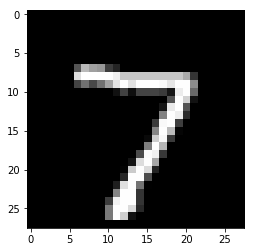

In [6]:
# first_img = x_test[0].reshape((-1,784))
# print(encoder.predict(first_img))
# print(vae.predict(first_img))
first_img = x_test[0].reshape((-1,784))
plt.imshow(x_test[0].reshape((28,28)),cmap='gray')
print(first_img.shape)
# print(encoder.predict(first_img))
print(enc_ffn.predict(encoder.predict(first_img)[2]))

In [0]:
# first_img = x_test[30].reshape((-1,784))
# plt.imshow(first_img.reshape((28,28)),cmap='gray')

#Hacking Image

In [8]:
!pip install foolbox

In [0]:
# check_img= x_test[44].reshape((-1,784))
# plt.imshow(x_test[44].reshape((28,28)),cmap='gray')
# print(check_img.shape)
# # print(encoder.predict(first_img))
# print(final_model.predict(check_img))

In [0]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack, BIM, SaliencyMapAttack,L1BasicIterativeAttack
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras

fmodel = KerasModel(final_model, bounds=(0, 1))

In [11]:
print(x_train.shape)

(60000, 784)


In [12]:
image = x_test[30] #Do not put test_img since it has been expanded .reshape((28,28,1))
label = 3
print(image.shape)

# run the attack
#attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(8, p=.5))
#attack = BIM(model=fmodel, criterion=TargetClassProbability(8, p=.6))
# attack = SaliencyMapAttack(model=fmodel, criterion=TargetClassProbability(7, p=.5))
attack = L1BasicIterativeAttack(model=fmodel, criterion=TargetClassProbability(8, p=.6))

# attack = DeepFoolAttack(model=fmodel, criterion=TargetClassProbability(1, p=.2))

adversarial = attack(image, label) #image[:, :, ::-1] For BGR

# show results
print(np.argmax(fmodel.predictions(adversarial)))
print(foolbox.utils.softmax(fmodel.predictions(adversarial))[2])
adversarial_rgb = adversarial[np.newaxis, :] #image[:, :, ::-1] For BGR
preds = final_model.predict(adversarial_rgb)

print("Prediction: ", preds)

(784,)
8
0.0064322227
Prediction:  [[0.01159638 0.0005911  0.00659292 0.16425109 0.00550312 0.22313882
  0.00428018 0.00933084 0.5647531  0.00996244]]


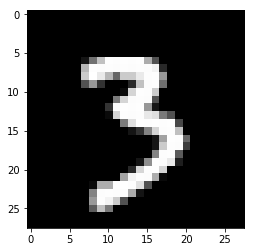

[[0.01832702 0.00062613 0.00477426 0.33829904 0.00175386 0.32264856
  0.00191275 0.00422744 0.3017412  0.00568966]]


In [17]:
from PIL import Image
check_img= x_test[30]
check_img = check_img.reshape((-1,784))
plt.imshow(check_img.reshape((28,28)),cmap='gray')
plt.show()
print(final_model.predict(check_img))

check_img *= 255.
check_img = check_img.reshape((28,28))
check_img = check_img.astype(np.uint8)


im = Image.fromarray(check_img)
im.save("VAE_MNIST_og_BIM.png")

# Downloading image
from google.colab import files
files.download("VAE_MNIST_og_BIM.png" ) 

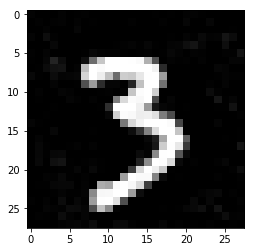

[[1.0760734e-02 5.7902787e-04 7.2215190e-03 1.4635122e-01 6.0522235e-03
  2.0052092e-01 4.7308910e-03 9.7566815e-03 6.0344499e-01 1.0581853e-02]]


In [18]:
adv_img = adversarial_rgb.reshape((-1,784))
plt.imshow(adversarial_rgb.reshape((28,28)),cmap='gray')
plt.show()

print(final_model.predict(adv_img))


adv_img *= 255.
adv_img = adv_img.reshape((28,28))

adv_img = adv_img.astype(np.uint8)


im = Image.fromarray(adv_img)
im.save("VAE_MNIST_Hacked_BIM.png")

# Downloading image
from google.colab import files
files.download("VAE_MNIST_Hacked_BIM.png" ) 